## Brillouin Zone module

A brief introduction to the Brillouin Zone module. It has two main classes: `KGrid` and `KPath`. The first one is
used to generate the Brillouin Zone of a given lattice, while the second one is used to generate a path in the Brillouin Zone.

#### Brillouin Zone

The 'KGrid' object has two main purposes. First create the k-mesh for a given number of k-points in each dimension and second
to provide a mapping into the irreduzible Brillouin zone. This requires a set of symmetry operations to be supplied at
instantiation of the object.


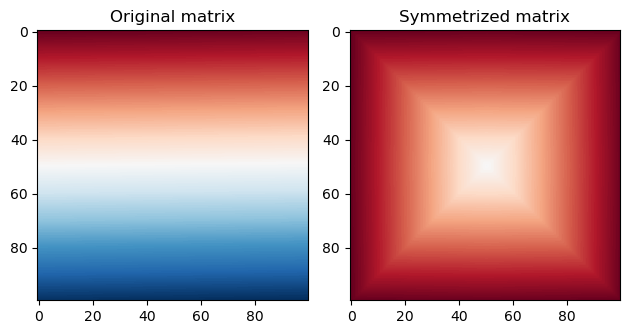

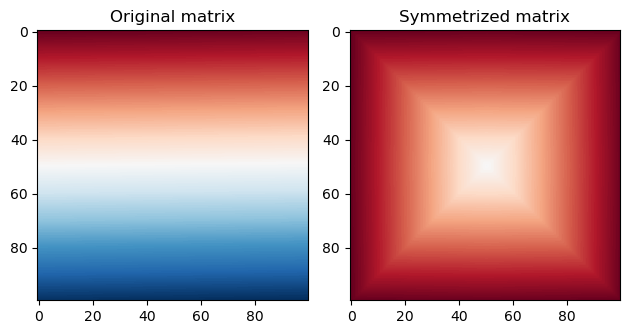

In [29]:
# load the module
import dga.brillouin_zone as bz
import numpy as np
import matplotlib.pyplot as plt
# Define the size of the k-mesh:
nk = (100,100,1) # typical for 2D lattices

# Define the symmetry:
sym = bz.two_dimensional_square_symmetries() # predefined 2D square symmetries. For new lattices it is recommended to
# sym = bz.quasi_one_dimensional_square_symmetries() # predefined 2D square symmetries. For new lattices it is recommended to
# sym = bz.two_dimensional_nematic_symmetries() # predefined 2D square symmetries. For new lattices it is recommended to
# first introduce a similar function.

# Create the KGrid object

k_grid = bz.KGrid(nk, sym)


# test matrix
mat = np.reshape(np.arange(np.prod(nk)),nk)

mat_irrk = k_grid.map_fbz2irrk(mat) # map the matrix to the irreducible Brillouin zone
mat_back = k_grid.map_irrk2fbz(mat_irrk,shape='mesh') # map the matrix back to the full Brillouin zone


plt.figure()
plt.subplot(1,2,1)
plt.imshow(mat[:,:,0],cmap='RdBu',vmin=0,vmax=np.prod(nk[0:2]))
plt.title('Original matrix')
plt.subplot(1,2,2)
plt.imshow(mat_back[:,:,0],cmap='RdBu',vmin=0,vmax=np.prod(nk[0:2]))
plt.title('Symmetrized matrix')
plt.tight_layout()





## Wannier Module:

The 'Wannier' module handles the tight-binding (kinetic) part of the Hamiltonian.

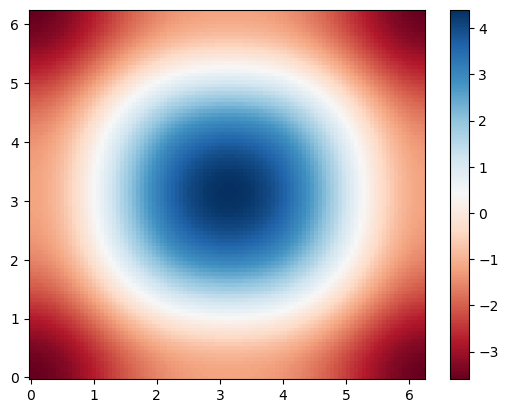

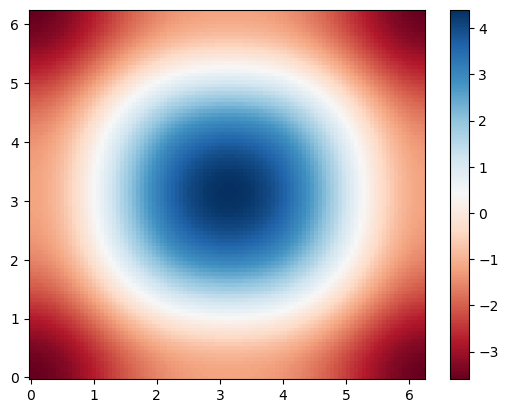

In [30]:
import dga.wannier as wannier
# Define the Hamitlonian in real space:

# hr = wannier.one_band_2d_t_tp_tpp(1,-0.2,0.1) # create tight-binding Hamiltonian from hopping parameters.
hr = wannier.WannierHr(*wannier.wannier_one_band_2d_t_tp_tpp(1,-0.2,0.1)) # Wannier object
ek = hr.get_ek_one_band(k_grid) # create the momentum-space Hamiltonian

plt.figure()
plt.pcolormesh(k_grid.kx,k_grid.ky,ek[:,:,0].real,cmap='RdBu')
plt.colorbar()

#### KPath object

Now that we have a Hamiltonian it is time to introduce the k-path object, which is primarily used for plotting quantities along
 a high-symmetry path in the Brillouin zone.


(0.0, 1.0)

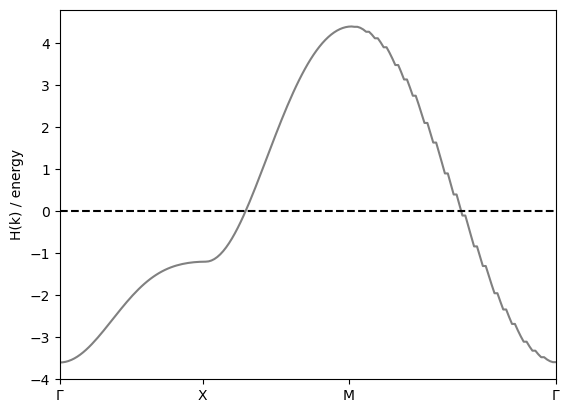

(0.0, 1.0)

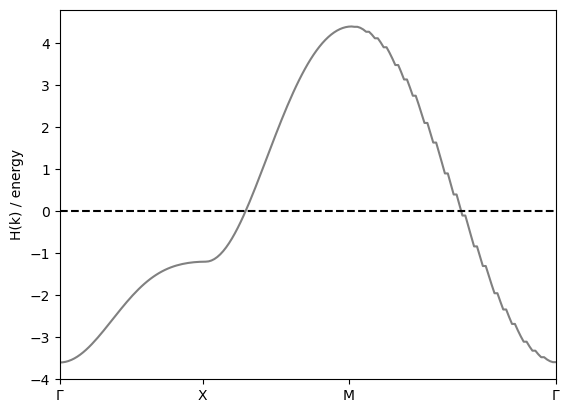

In [31]:
k_path_string = 'Gamma-X-M-Gamma'
k_path = bz.KPath(nk,k_path_string)

ek_kpath = k_path.map_to_kpath(ek)

plt.figure()
plt.plot(k_path.k_axis,ek_kpath.real,'-',color='grey')
plt.hlines(0,k_path.k_axis[0],k_path.k_axis[-1],linestyles='dashed',color='k')
plt.ylabel('H(k) / energy')
plt.xticks(k_path.x_ticks,k_path.labels)
plt.xlim(0,1)

## Matsubara Frequqencies Module

The `MatsubaraFrequencies` class is used to generate the Matsubara frequencies for a given temperature and number of Matsubara frequencies.

The main function is mf.vn/mf.wn for fermionic/bosonic frequencies respectively.

The functions are overloaded and create the indices if beta is not supplied, while they create the frequencies if beta is
supplied. Note that they do NOT include the imaginary unit.

In [ ]:
import dga.matsubara_frequencies as mf
import numpy as np
# Define the temperature and number of Matsubara frequencies
beta = 10.
n = 100

# Create the MatsubaraFrequencies object
v = mf.vn(beta,n) # np.pi/beta * (2*np.arange(-n,n)+1)
vn = mf.vn(n) # (np.arange(-n,n))
test = np.arange(-100,100)
vn2 = mf.vn(beta,test)

print(v,vn,vn2)

## Green's Function Module

The 'two_point' module contains objects and functions to handle two-point object, primarily the SelfEnergy and the
(single-particle) Green's function.

#### SelfEnergy

The self-enery object is a subclass of the `two_point` class. On intantiation it requires the self-energy on a finite Matsubara
 grid. Subsequently, the tail behaviour is automatically fitted and a critical cutoffvalue for when to use the tail is
 determined. Tailfitting can be avaoided by directly supplying smom0 and smom1 (first and second moment of the self-energy).

In [ ]:
# Define custom self-energy
import dga.matsubara_frequencies as mf
import matplotlib.pyplot as plt
import dga.two_point as tp
import numpy as np

# Define the temperature and number of Matsubara frequencies
beta = 10.
n = 500
vn = mf.vn(beta,n)

# Define the self-energy
u = 8 # interaction strength
totdens = 0.8 # total density of electrons in the system
smom0 = tp.get_smom0(u,totdens)
smom1 = tp.get_smom1(u,totdens)
siw = smom0-1/(2+0.1*np.abs(vn)**2) + 1j * vn*smom1/(20+1*vn**2) # this is not a physical self-energy
siw += np.random.normal(0,0.01,2*n) + 1j * np.random.normal(0,0.02,2*n) # add some noise
def symmetrize(mat):
    return 0.5*(mat.real+ mat.real[::-1]) + 1j*0.5*(mat.imag - mat.imag[::-1])
siw = symmetrize(siw)

plt.figure()
plt.subplot(1,2,1)
plt.plot(vn.real,siw.real,'-o',color='cornflowerblue')
plt.title('$\Re \Sigma$')
plt.subplot(1,2,2)
plt.plot(vn.real,siw.imag,'-o',color='firebrick')
plt.title('$\Im \Sigma$')
plt.tight_layout()
# print(vn)
# print(siw.real - siw.real[::-1])
# print(siw.imag + siw.imag[::-1])

#
np.size(np.random.normal(0,0.1,n))

In [ ]:
# Create the SelfEnergy object
import dga.dga_io as io

data_1p = io.load_1p_data_w2dyn(path='../test/2')
siw_obj = tp.SelfEnergy(siw[None,None,None,:],beta) # the self-energy is supplied as a 4D array, where the first three
# dimensions are the indices of the self-energy and the last dimension is the Matsubara frequency.
siw_new = siw_obj.get_siw(niv=n)[0,0,0,:]


plt.figure()
plt.subplot(1,2,1)
plt.plot(vn.real,siw.real,'-o',color='cornflowerblue',markeredgecolor='k')
plt.plot(vn.real,siw_new.real,'-o',color='firebrick',markeredgecolor='k')
plt.title('$\Re \Sigma$')
plt.subplot(1,2,2)
plt.plot(vn.real,siw.imag,'-o',color='cornflowerblue',markeredgecolor='k')
plt.plot(vn.real,siw_new.imag,'-o',color='firebrick',markeredgecolor='k')
plt.title('$\Im \Sigma$')
plt.tight_layout()

plt.figure()
plt.subplot(1,2,1)
plt.plot(vn.real,siw.real,'-o',color='cornflowerblue',markeredgecolor='k')
plt.plot(vn.real,siw_new.real,'-o',color='firebrick',markeredgecolor='k')
plt.title('$\Re \Sigma$')
plt.subplot(1,2,2)
plt.plot(vn.real,siw.imag,'-o',color='cornflowerblue',markeredgecolor='k')
plt.plot(vn.real,siw_new.imag,'-o',color='firebrick',markeredgecolor='k')
plt.title('$\Im \Sigma$')


----------------
Smom0/Predicted:  3.2 3.2003886192223354
Smom1/Predicted:  -15.36 -15.64732109233925
----------------


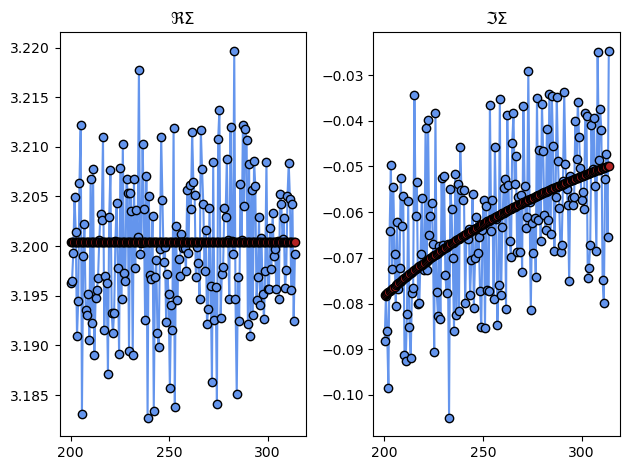

----------------
Smom0/Predicted:  3.2 3.2002859159510115
Smom1/Predicted:  -15.36 -14.74915007408302
----------------


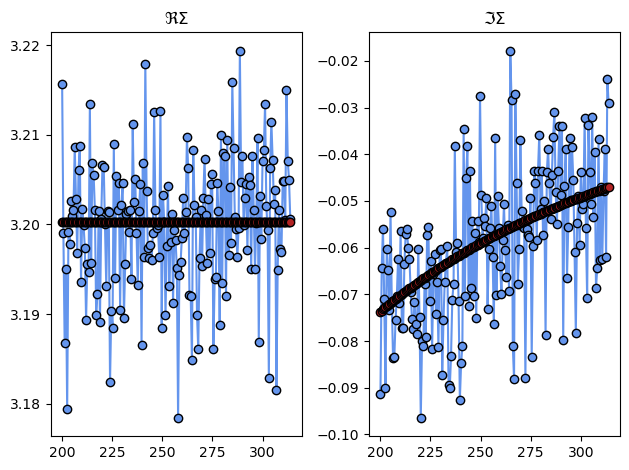

In [35]:
ind = vn > 200
plt.figure()
plt.subplot(1,2,1)
plt.plot(vn.real[ind],siw.real[ind],'-o',color='cornflowerblue',markeredgecolor='k')
plt.plot(vn.real[ind],siw_new.real[ind],'-o',color='firebrick',markeredgecolor='k')
plt.title('$\Re \Sigma$')
plt.subplot(1,2,2)
plt.plot(vn.real[ind],siw.imag[ind],'-o',color='cornflowerblue',markeredgecolor='k')
plt.plot(vn.real[ind],siw_new.imag[ind],'-o',color='firebrick',markeredgecolor='k')
plt.title('$\Im \Sigma$')
plt.tight_layout()

print('----------------')
print('Smom0/Predicted: ',smom0,siw_obj.smom0)
print('Smom1/Predicted: ',smom1,siw_obj.smom1)
print('----------------')

## Green's Function

The Green's function build atop the self-energy:

G(iv_n,k) = 1/(ivn - ek + mu - siw(ivn,k))


(-20.0, 20.0)

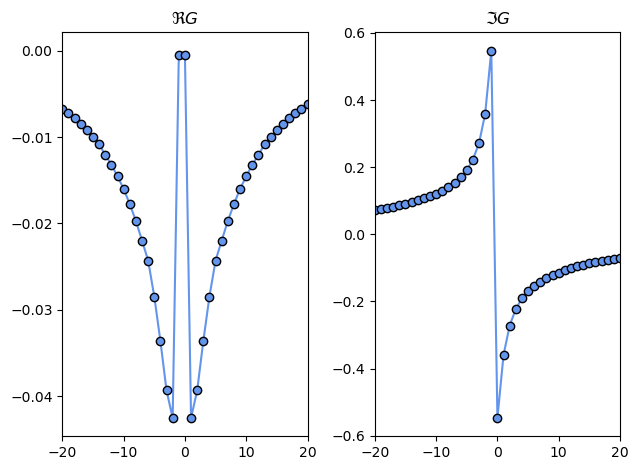

In [45]:
# Build the Green's function:

giwk = tp.GreensFunction(siw_obj,ek,n=totdens) # supply either n or mu

giw = k_grid.k_mean(giwk.g_full(),type='fbz-mesh') # create local Green's function for easier plotting



plt.figure()
plt.subplot(1, 2, 1)
plt.plot(giwk.vn.real, giw.real, '-o', color='cornflowerblue', markeredgecolor='k')
plt.title('$\Re G$')
plt.xlim(-20,20)
plt.subplot(1, 2, 2)
plt.plot(giwk.vn.real, giw.imag, '-o', color='cornflowerblue', markeredgecolor='k')
plt.title('$\Im G$')
plt.tight_layout()
plt.xlim(-20,20)